<a href="https://colab.research.google.com/github/rmanicav/21Days-21Projects-MachineLearning/blob/main/sarima_anly_fcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project 6: Time Series Analysis & Forecasting**

Project Objective: To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
!git clone "https://github.com/HarshvardhanSingh-13/Datasets"

Cloning into 'Datasets'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 335 (delta 22), reused 0 (delta 0), pack-reused 242 (from 1)
Receiving objects: 100% (335/335), 302.68 MiB | 29.83 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Updating files: 100% (243/243), done.


In [ ]:
df = pd.read_csv('/content/Datasets/Airline Timeseries/airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


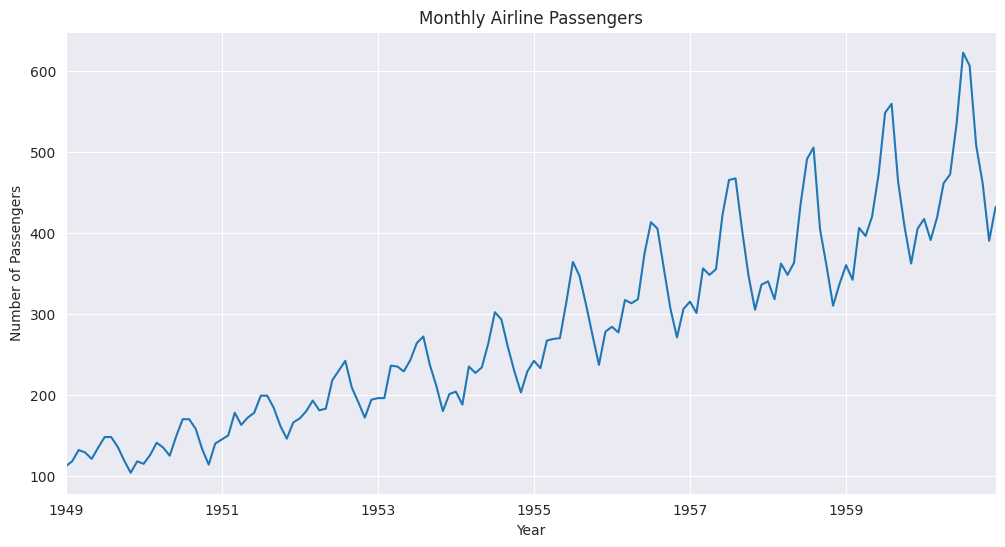

In [ ]:
#Step 2: Exploratory Data Analysis & Decomposition
# fixed the error in graph in given example
df['Passengers'].plot()
plt.title('Monthly Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

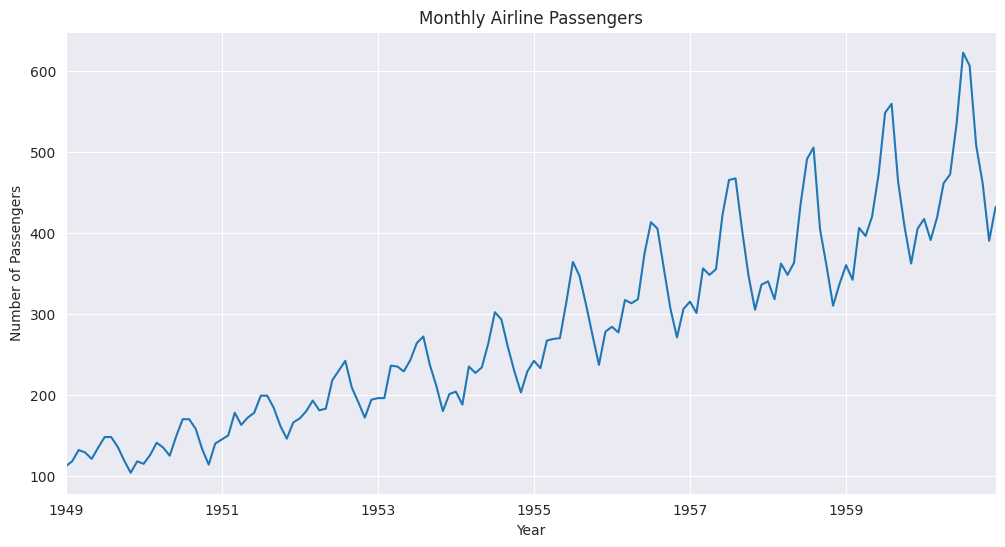

In [ ]:
df['Passengers'].plot()
plt.title('Monthly Airline Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

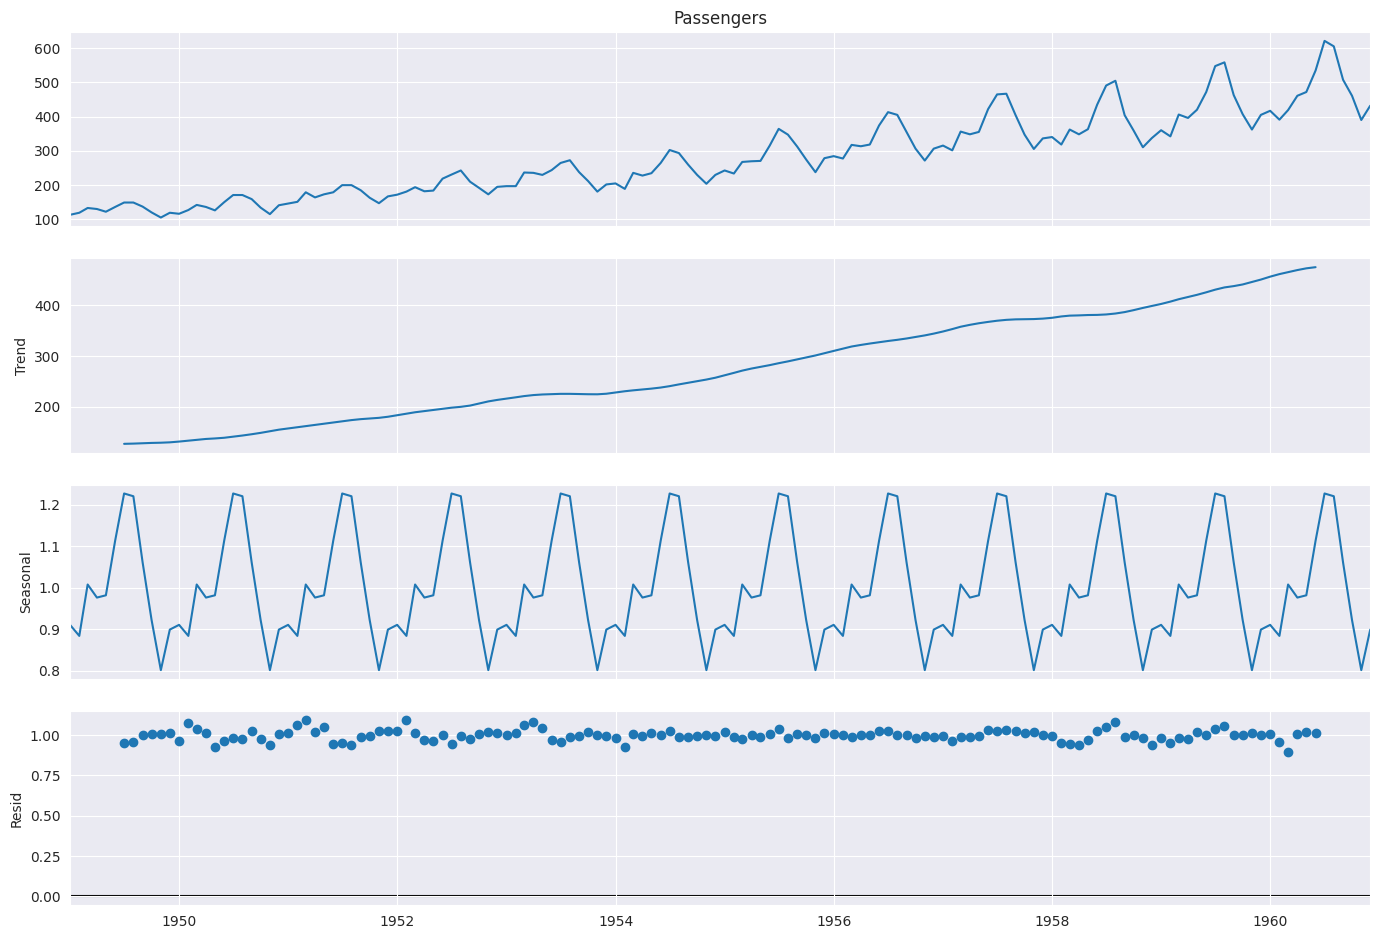

In [ ]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [ ]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


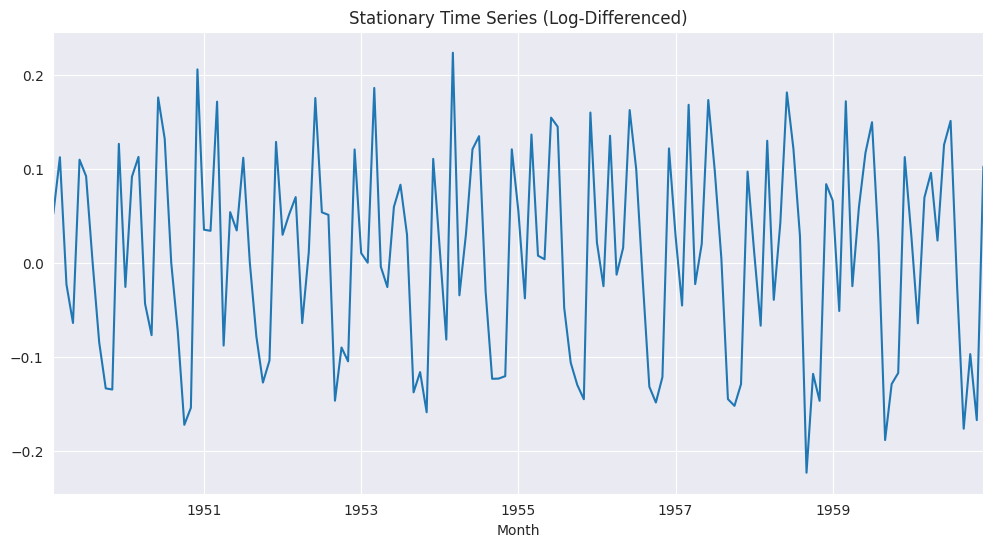

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

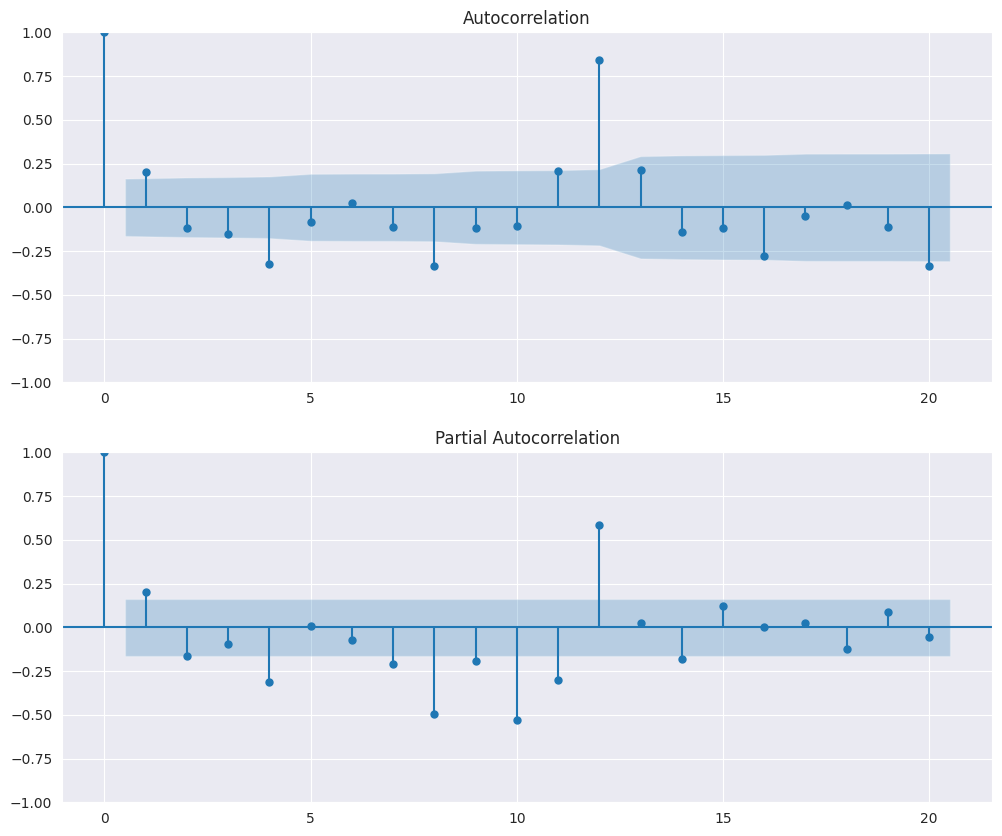

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

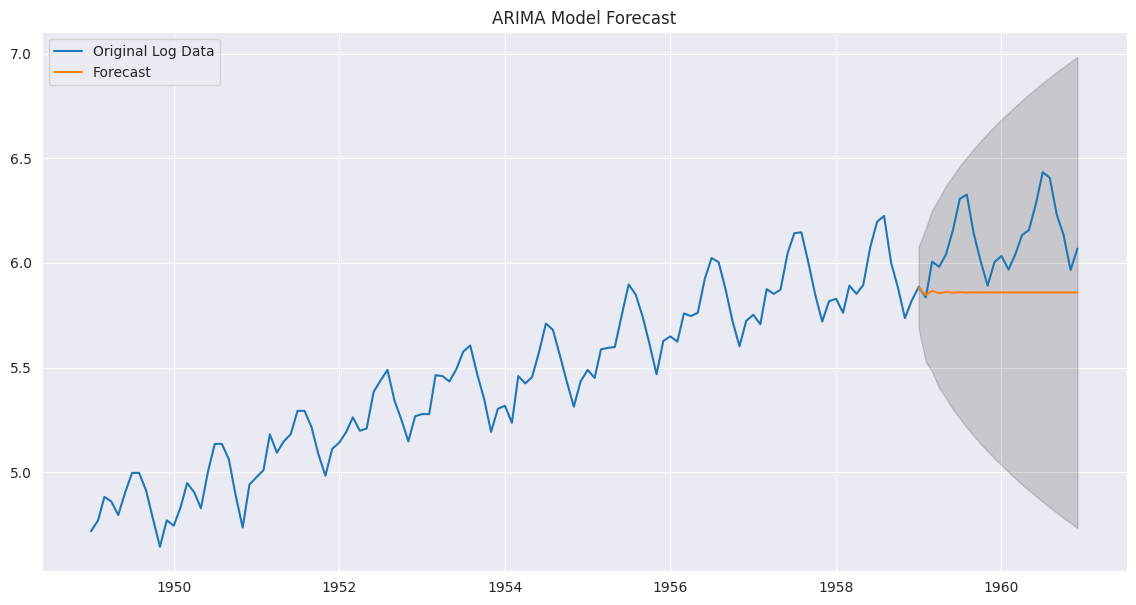

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

#Step 6: Building the ARIMA Model
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Ensure the training data has a frequency set
train_data = train_data.asfreq('MS')

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

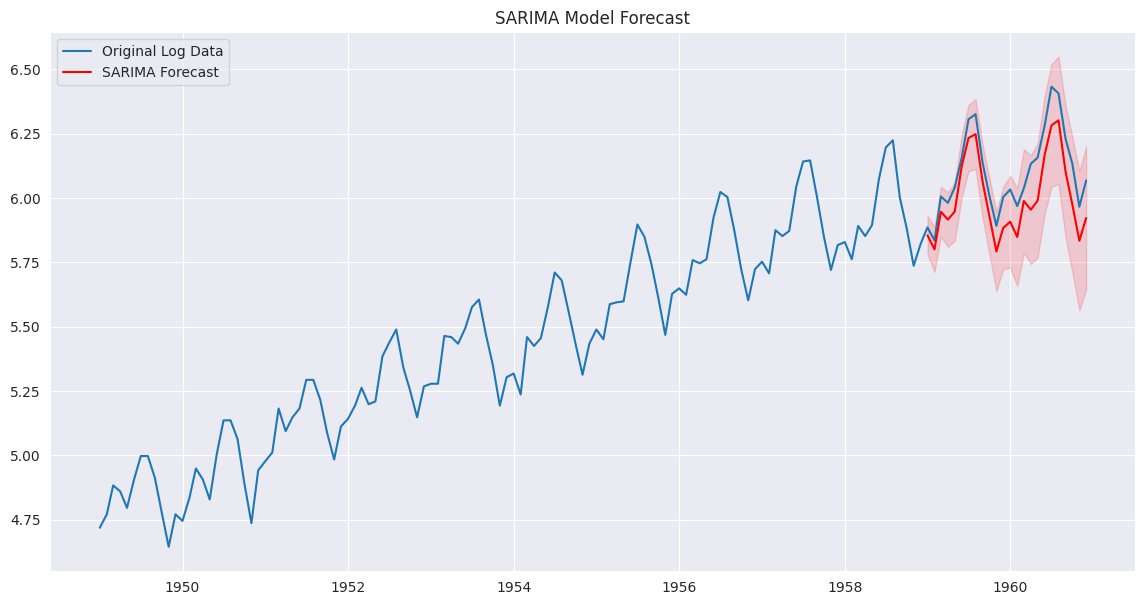

In [ ]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA Model RMSE: 48.25


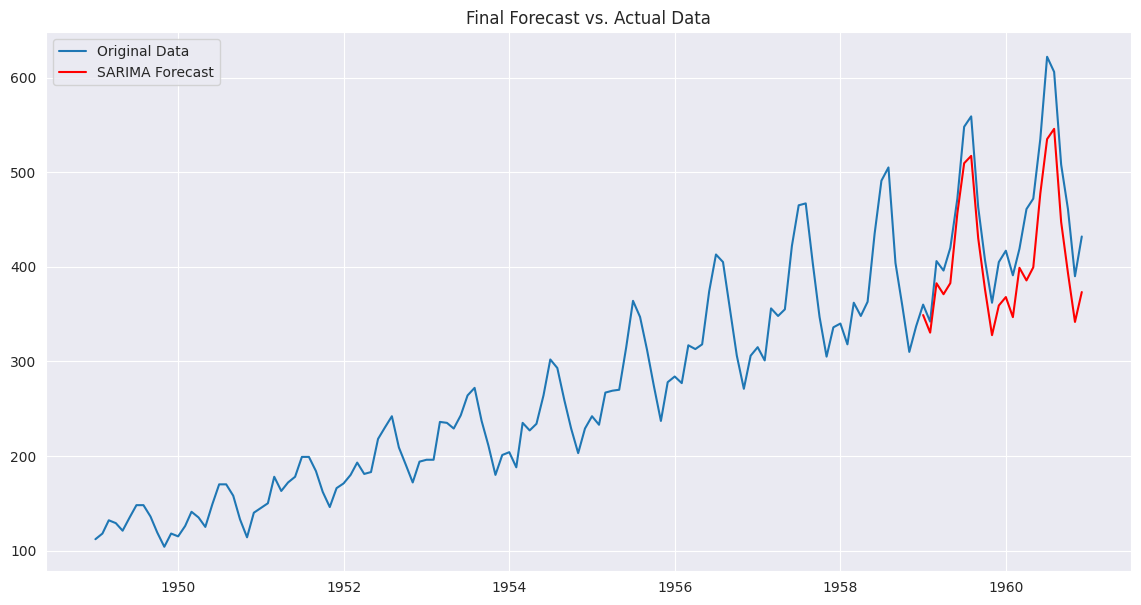

In [ ]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

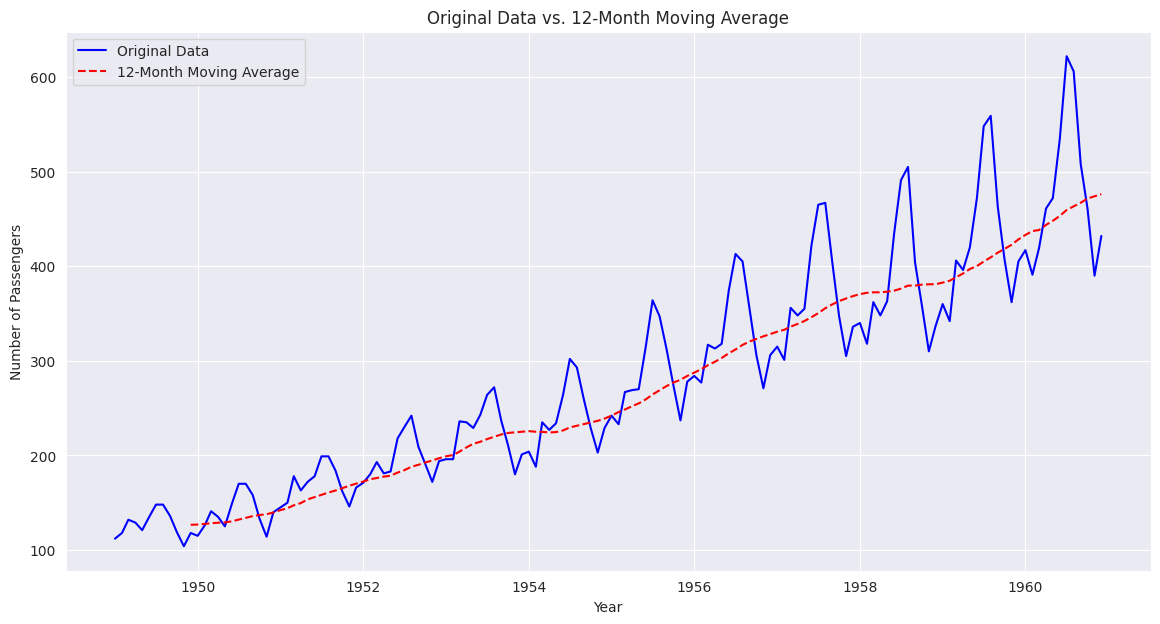

In [ ]:
# Calculate the rolling mean with a window size of 12
df['MovingAverage'] = df['Passengers'].rolling(window=12).mean()

# Plot the original data and the moving average
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.title('Original Data vs. 12-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

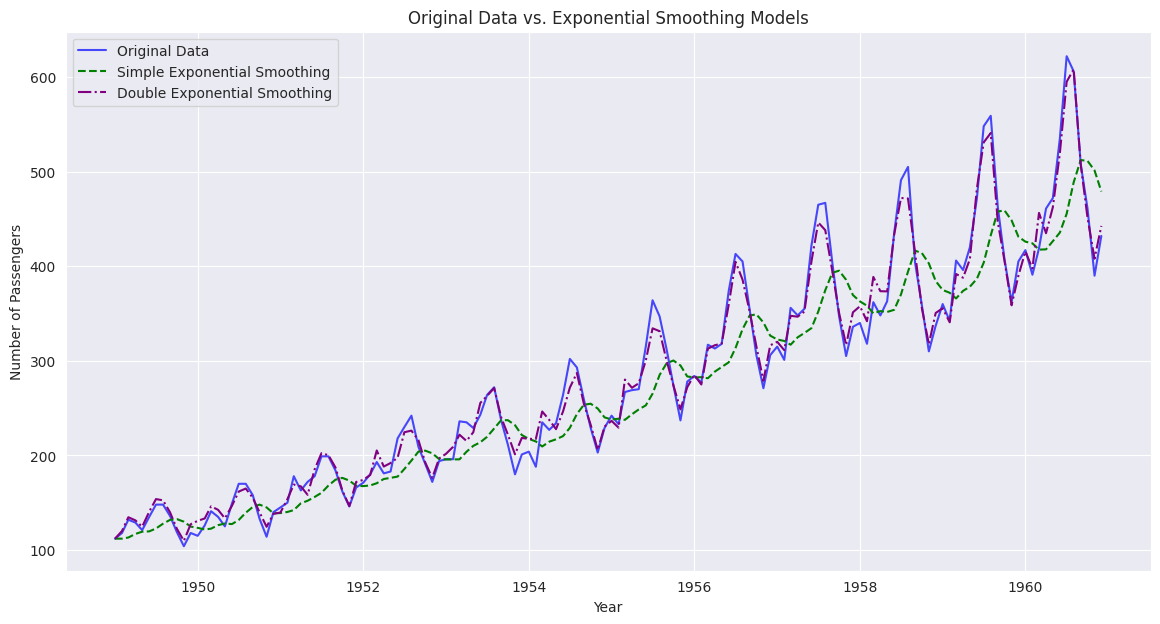

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# Explicitly set the frequency of the DataFrame's index to 'MS' (Month Start)
df.index.freq = 'MS'

# 2. Fit a simple exponential smoothing model
ses_model = SimpleExpSmoothing(df['Passengers']).fit(smoothing_level=0.2, optimized=False)
df['SimpleExpSmoothing'] = ses_model.fittedvalues

# 3. Fit a double exponential smoothing model
des_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['DoubleExpSmoothing'] = des_model.fittedvalues

# 4. Plot the original data and the fitted values from both models
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['SimpleExpSmoothing'], label='Simple Exponential Smoothing', color='green', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing', color='purple', linestyle='-.')
plt.title('Original Data vs. Exponential Smoothing Models')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

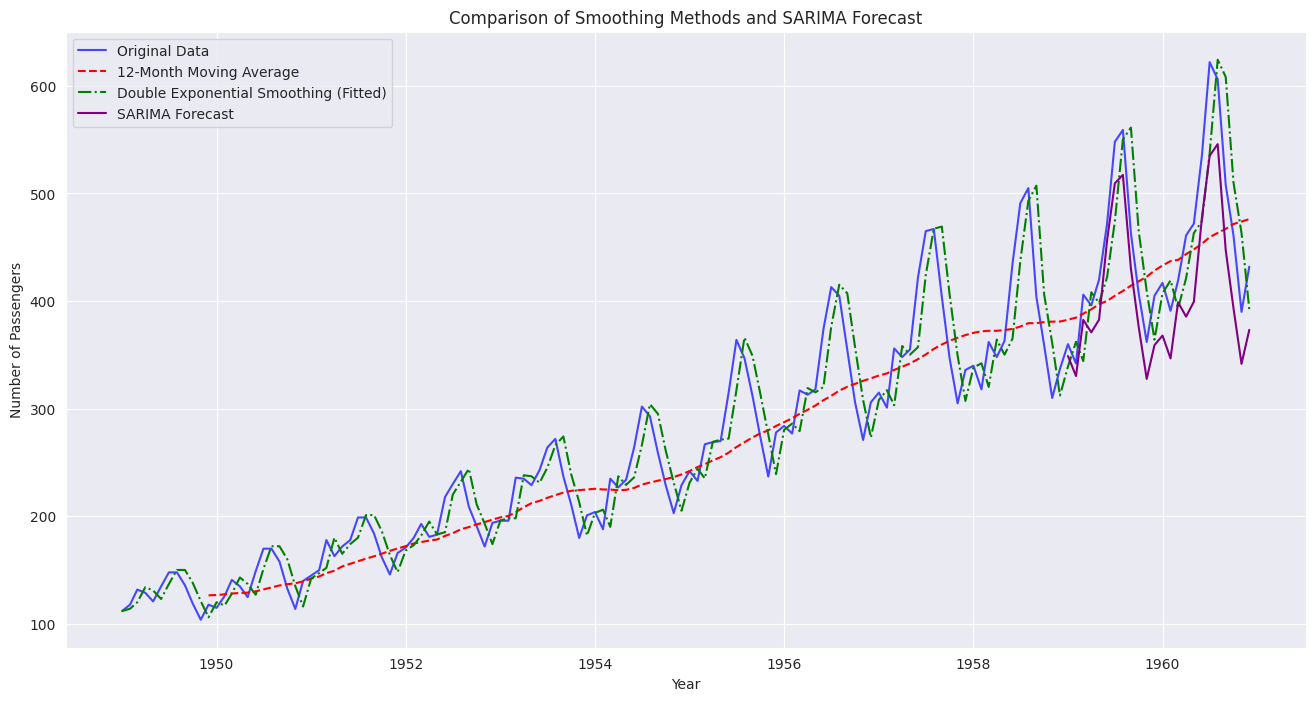

In [ ]:
# Implement Double Exponential Smoothing for comparison
# We need to re-fit the DoubleExpSmoothing model as it was not saved as a variable
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Double Exponential Smoothing model on the entire data for visualization
# Assuming an additive trend based on the initial plot
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Generate a plot comparing original, MA, Double ES, and SARIMA forecasts
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
# Plot SARIMA forecast (need to re-run SARIMA forecast as the variable is not available)
# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

**Submission Criteria**

*  Make the p value less than 0.05 and then build the ARIMA model and share
the notebook with me

In [ ]:
# Retest for stationarity
test_stationarity(df_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


# Task
Apply second-order differencing to the log-transformed data and re-run the Dickey-Fuller test. If the p-value is less than 0.05, then build an ARIMA model with the differencing parameter 'd' set to 2.

## Apply Second Differencing

### Subtask:
Apply a second order differencing to the log-transformed data (`df_log`) to further stabilize the series and reduce the p-value.


**Reasoning**:
To achieve a p-value less than 0.05 for stationarity, I will apply a second-order differencing to the log-transformed data, as specified in the instructions. This involves differencing the already first-differenced series `df_diff` and storing it in a new variable `df_diff2`.



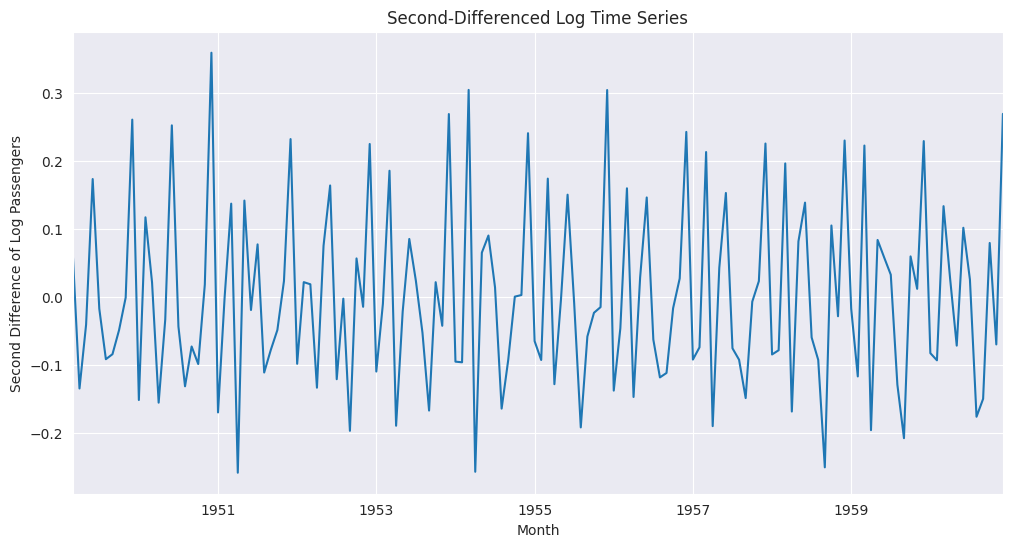

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [ ]:
df_diff2 = df_diff.diff().dropna()

# Plot the second-differenced series
df_diff2.plot()
plt.title('Second-Differenced Log Time Series')
plt.xlabel('Month')
plt.ylabel('Second Difference of Log Passengers')
plt.show()

# Retest for stationarity with the second-differenced series
test_stationarity(df_diff2)

**Reasoning**:
The Dickey-Fuller test on the second-differenced log data (df_diff2) yielded a p-value of 7.419305e-13, which is significantly less than 0.05, indicating stationarity. According to the instructions, the next step is to build an ARIMA model with the differencing parameter 'd' set to 2. I will first prepare the training and testing datasets from the log-transformed data and then build and fit the ARIMA model with the specified differencing order.



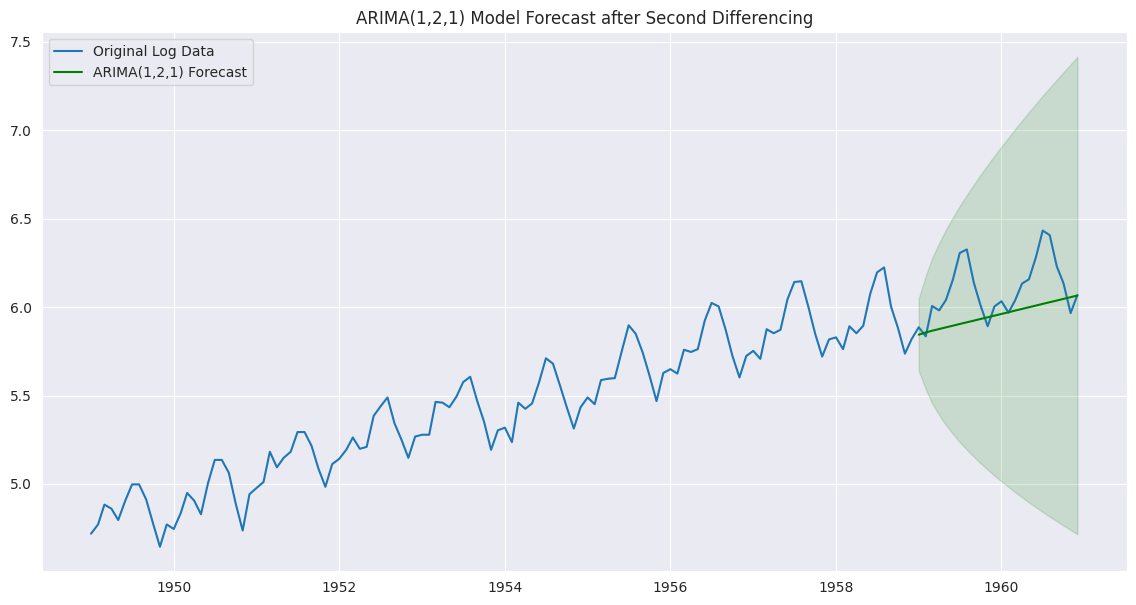

In [ ]:
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Ensure the training data has a frequency set
train_data = train_data.asfreq('MS')

# Build ARIMA model with d=2
# Using p=1 and q=1 as a starting point, similar to the previous ARIMA model
model_d2 = ARIMA(train_data, order=(1, 2, 1))
arima_result_d2 = model_d2.fit()

# Get forecast
forecast_d2 = arima_result_d2.get_forecast(steps=len(test_data))
forecast_ci_d2 = forecast_d2.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast_d2.predicted_mean, label='ARIMA(1,2,1) Forecast', color='green')
plt.fill_between(forecast_ci_d2.index, forecast_ci_d2.iloc[:, 0], forecast_ci_d2.iloc[:, 1], color='g', alpha=.15)
plt.title('ARIMA(1,2,1) Model Forecast after Second Differencing')
plt.legend()
plt.show()

**Reasoning**:
The ARIMA(1,2,1) model has been built and its forecast plotted. Now, I need to evaluate the model's performance by calculating the Root Mean Squared Error (RMSE) on the original scale and then visualize the forecast against the actual data. This involves reversing the log transformation for the forecasted values and the original test data, calculating the RMSE, and then plotting the final results to compare the model's predictions with the actual values.



ARIMA(1,2,1) Model RMSE: 94.99


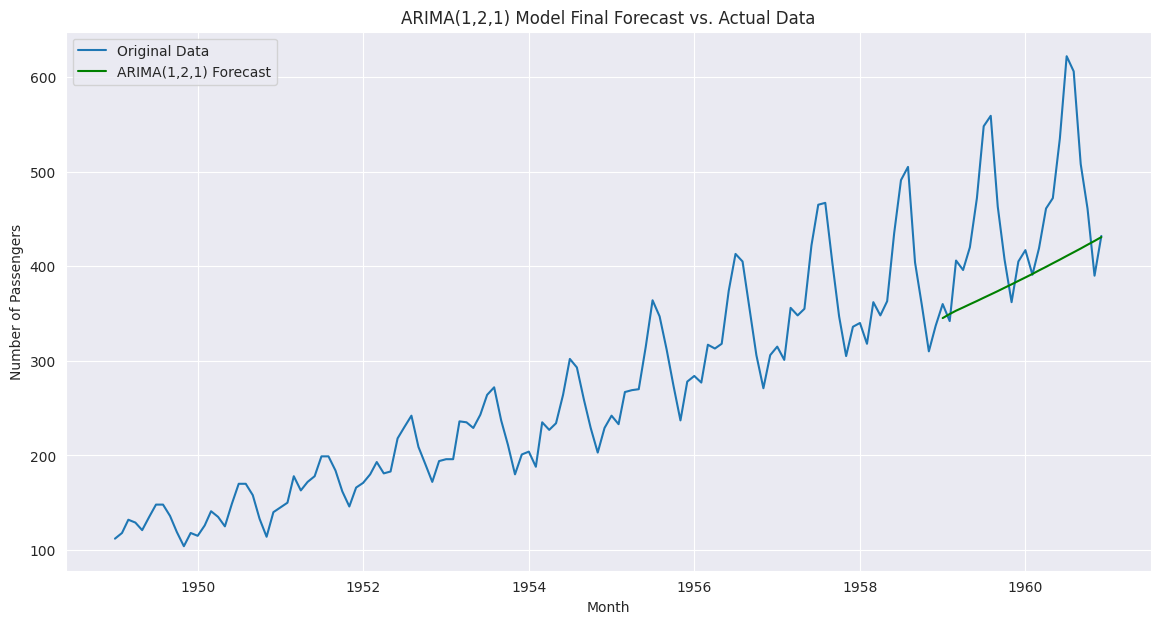

In [ ]:
original_test_data = np.exp(test_data)
arima_predictions_d2 = np.exp(forecast_d2.predicted_mean)

# Calculate RMSE for the ARIMA(1,2,1) model
rmse_d2 = np.sqrt(mean_squared_error(original_test_data, arima_predictions_d2))
print(f"ARIMA(1,2,1) Model RMSE: {rmse_d2:.2f}")

# Plot final results with original scale
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(arima_predictions_d2, label='ARIMA(1,2,1) Forecast', color='green')
plt.title('ARIMA(1,2,1) Model Final Forecast vs. Actual Data')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

## Summary:

### Data Analysis Key Findings
*   Applying second-order differencing to the log-transformed data resulted in a stationary series, confirmed by a Dickey-Fuller test p-value of 7.419305e-13, which is significantly less than the 0.05 threshold.
*   An ARIMA(1,2,1) model was built using the second-differenced log-transformed data, effectively incorporating a differencing parameter 'd' of 2.
*   The RMSE for the ARIMA(1,2,1) model, after re-transforming the predictions back to the original scale, was calculated to be 94.99.

### Insights or Next Steps
*   Given the successful stationarization and a specific RMSE value, further model optimization could involve exploring different 'p' and 'q' parameters for the ARIMA model (e.g., using ACF/PACF plots of the differenced series) to potentially improve forecasting accuracy.
*   The model can now be used for future passenger demand forecasting, but it would be beneficial to monitor its performance over time and retrain it periodically with new data to maintain accuracy.
